In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp


In [2]:
# fucking-a, need to import and setup the stacker first for some registry reason
import lsst.sims.maf.stackers as stackers
class SaturationStacker(stackers.BaseStacker):
    """Calculate the saturation limit of a point source

    pixscale : float (0.2)
        Acrsec per pixel
    gain : 2.3
        electrons per adu
    """
    colsAdded = ['saturation_mag']

    def __init__(self, seeingCol='seeingFwhmEff', skybrightnessCol='skyBrightness',
                 exptimeCol='visitExposureTime', nexpCol='numExposures',
                 filterCol='filter', airmassCol='airmass',
                 saturation_e=90e3, zeropoints=None, km=None, pixscale=0.2, gain=2.3):
        self.units = ['mag']
        self.colsReq = [seeingCol, skybrightnessCol, exptimeCol, nexpCol, filterCol, airmassCol]
        self.seeingCol = seeingCol
        self.skybrightnessCol = skybrightnessCol
        self.exptimeCol = exptimeCol
        self.nexpCol = nexpCol
        self.filterCol = filterCol
        self.airmassCol = airmassCol
        self.saturation_adu = saturation_e/gain
        self.pixscale = 0.2
        if zeropoints is None:
            names = ['u', 'g', 'r', 'i', 'z', 'y']
            types = [float]*6
            # Counts at airmass 1, 30s? grabbed from:
            # https://github.com/lsst-pst/syseng_throughputs/blob/master/notebooks/Syseng%20Throughputs%20Repo%20Demo.ipynb
            self.zeropoints = np.array([27.03, 28.38, 28.15, 27.86, 27.46, 26.68])
            self.zeropoints = self.zeropoints.view(list(zip(names, types)))
        else:
            self.zeropoints = zeropoints

        if km is None:
            # XXX--again, should be somewhere to grab these values from.
            self.km = np.array([0.491, 0.213, 0.126, 0.096, 0.069, 0.170]).view(list(zip(names, types)))
        else:
            self.km = km

    def _run(self, simData, cols_present=False):
        for filtername in np.unique(simData[self.filterCol]):
            in_filt = np.where(simData[self.filterCol] == filtername)[0]
            sky_counts = 10.**(0.4*(self.zeropoints[filtername] - simData[self.skybrightnessCol][in_filt])) * self.pixscale**2
            sky_counts = sky_counts * simData[self.exptimeCol][in_filt]/simData[self.nexpCol][in_filt]
            remaining_counts_peak = (self.saturation_adu - sky_counts)
            # Now to figure out how many counts there would be total, if there are that many in the peak
            sigma = 2.354*simData[self.seeingCol]
            source_counts = remaining_counts_peak *2.*np.pi*(sigma/self.pixscale)**2

            count_rate = source_counts / simData[self.nexpCol] / simData[self.exptimeCol]
            simData['saturation_mag'][in_filt] = -2.5*np.log10(count_rate) + self.zeropoints[filtername]
            # Airmass correction
            simData['saturation_mag'][in_filt] -= self.km[filtername]*(simData[self.airmassCol] - 1.)

        return simData


In [3]:

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

In [4]:
# can grab db from: https://lsst.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs1.5/short_exp/
dbFile = 'short_exp_5ns_5expt_v1.5_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [5]:
bundleList = []

stacker = SaturationStacker()

sql = 'filter="r" and visitExposureTime > 20'
metric = metrics.MedianMetric(col='saturation_mag')
slicer = slicers.HealpixSlicer()
summaryStats = []
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                            stackerList=[stacker]))


sql = 'filter="r" and visitExposureTime < 20'

bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                            stackerList=[stacker]))


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Querying database SummaryAllProps with constraint filter="r" and visitExposureTime > 20 for columns ['skyBrightness', 'filter', 'visitExposureTime', 'fieldRA', 'seeingFwhmEff', 'airmass', 'fieldDec', 'numExposures']
Found 482646 visits
Running:  ['opsim_Median_saturation_mag_r_and_visitExposureTime_gt_20_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="r" and visitExposureTime < 20 for columns ['skyBrightness', 'filter', 'visitExposureTime', 'fieldRA', 'seeingFwhmEff', 'airmass', 'fieldDec', 'numExposures']
Found 138694 visits
Running:  ['opsim_Median_saturation_mag_r_and_visitExposureTime_lt_20_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="r" and visitExposureTime > 20" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 262 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 12.8218  dipole: lon: 146.844, lat: -51.3444, amp: 0.269148
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="r" and visitExposureTime < 20" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 229 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 10.8548  dipole: lon: 159.194, lat: -39.4693, amp: 0.267182
  mono, lon, lat, amp


Plotting complete.


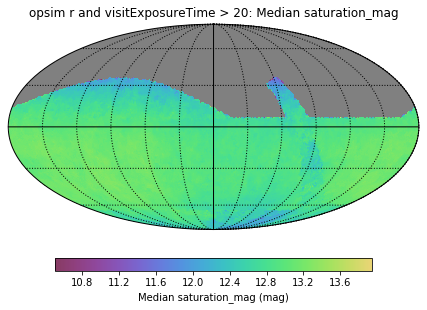

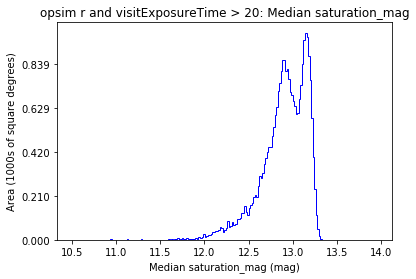

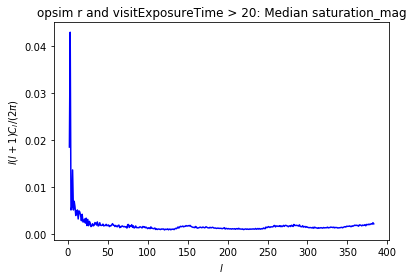

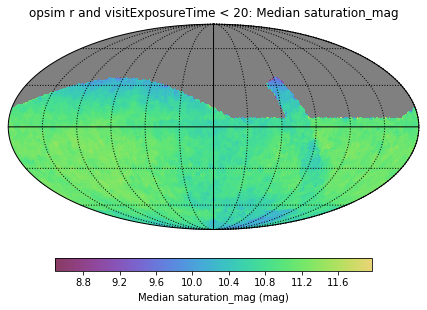

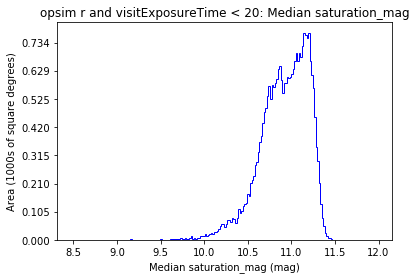

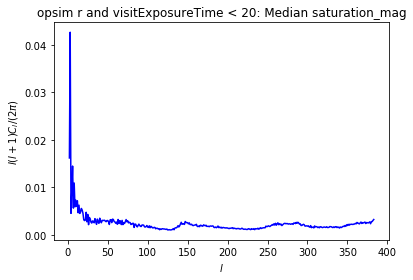

In [6]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)